# Исследование данных о продажах и популярности компьютерных игр

**Цель исследования:**
1. Изучить сколько игр выпускалось в разные годы. Определить важны ли данные за все периоды.
2. Оценить изменение продаж по платформам. Определить платформы с наибольшими суммарными продажами и построить распределение по годам. Выявить за какой характерный срок появляются новые и исчезают старые платформы.
3. Определить какие платформы лидируют по продажам, растут или падают.
4. Построить график «ящик с усами» по глобальным продажам игр в разбивке по платформам и описать результат.
5. Оценить, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.
6. Определить влияние жанра на количество проданных копий.
7. Составить портрет пользователя каждого региона.
8. Проверить две гипотезы:
- средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

**Ход исследования**

Данные получены из файла ` /datasets/games.csv`. О качестве данных ничего не известно. Поэтому перед исследовательским анализом понадобится обзор данных и их предобработка. 

**Этапы исследования**
 1. Обзор данных.
 2. Предобработка данных - поиск пропущенных значений, изменение типов данных, поиск дубликатов, устранение выбивающихся значений, корректировка названий столбцов, добавление новых столбцов для исследования.
 3. Исследовательский анализ данных.
 4. Составление портретов пользователей по регионам.
 5. Проверка гипотез.
 
**Оглавление**
<a id='section_id7'></a>
 1. [Импорт библиотек и обзор данных](#section_id1)
 2. [Предобработка данных](#section_id2)
 3. [Исследовательский анализ данных](#section_id3)
 4. [Портреты пользователей каждого региона](#section_id4)
 5. [Проверка гипотез](#section_id5)
 6. [Результаты исследования](#section_id6)

## 1. Импорт библиотек и обзор данных
<a id='section_id1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
try:
    data = pd.read_csv('/datasets/games.csv') # загрузим данные
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv') # загрузим данные

In [3]:
data.info() # изучим общую информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
data.head() # посмотрим первые 5 строк таблицы

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
data.shape # посмотрим общий размер таблицы

(16715, 11)

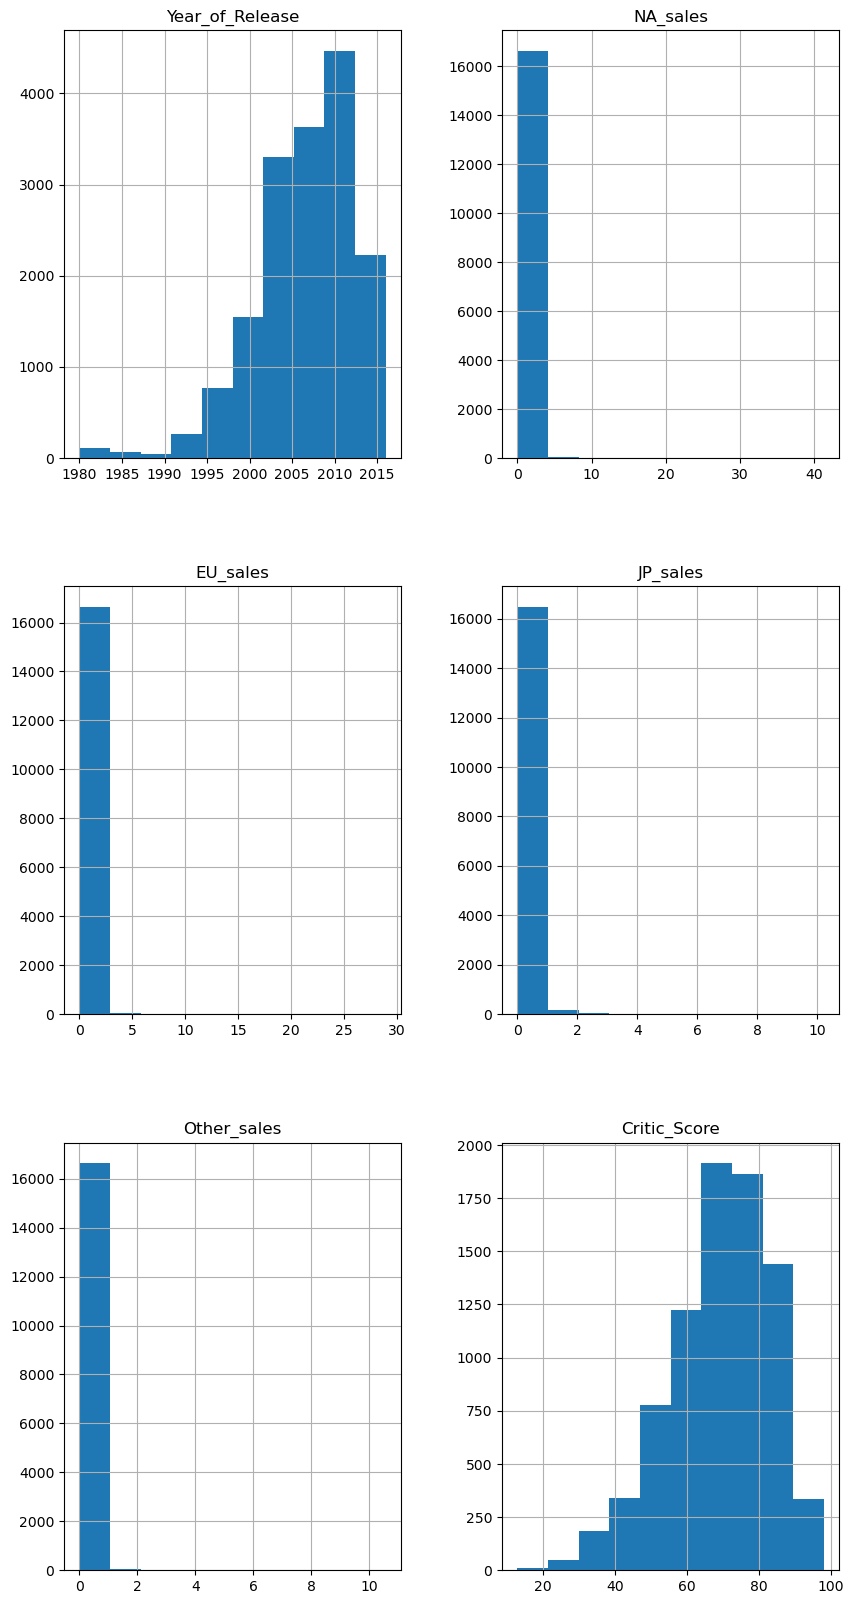

In [6]:
data.hist(figsize=(10,20)); # построим гисторгаммы для всех колонок чтобы получить общую информацию

**Выводы:**<br>
В ходе обзора данных выделены следующие недостатки:<br>
- Name: 2 значения пропущено, скорей всего некритично;
- Year_of_Release: проущено больше значений и тип данных float, хотя по логике должен быть int;
- Genre: 2 значения пропущено, скорей всего некритично;
- Critic_Score: очень много пропусков, требуется более детальное изучение;
- User_Score: очень много пропусков, формат данных ожидалось бы увидеть float, а не object, будем анализировать;
- Rating: очень много пропусков, будем анализировать и принимать решение что делать.

[Оглавление](#section_id7)

## 2. Предобработка данных
<a id='section_id2'></a>

### Приведение названия колонок в нижний регистр

In [7]:
data.columns = data.columns.str.lower() # приводим названия столбцов в нижний регистр

In [8]:
data.columns # проверяем названия колонок, все выглядит нормально

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [9]:
print(data.duplicated().sum()) # проверим на наличие явных дубликатов

0


### Обработка пропусков

In [10]:
# посмотрим долю пропусков во всех колонках
pd.DataFrame(round(data.isna().mean()*100,3)).style.background_gradient(low=1, high=0, vmax=5) 

,0
name,0.012000
platform,0.000000
year_of_release,1.609000
genre,0.012000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.319000
user_score,40.090000


In [11]:
data['year_of_release'].unique() # посмотрим уникальные значения в поле года выпуска

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

In [12]:
data['genre'].unique() # посмотрим уникальные значения в поле жанра

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

In [13]:
data[data['genre'].isnull()] # посмотрим сколько продаж потеряем, если удалим строки без жанра и наименования игр

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [14]:
# удалим данные с пропусками в колонке year_of_release и genre - их меньше 5% и сумма продаж по ним незначительна
data = data.dropna(subset=['year_of_release','genre']).reset_index(drop=True)

In [15]:
# проверим в каких столбцах еще остались пропуски
pd.DataFrame(round(data.isna().mean()*100,3)).style.background_gradient(low=1, high=0, vmax=5)

,0
name,0.000000
platform,0.000000
year_of_release,0.000000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.453000
user_score,40.167000


In [16]:
data['critic_score'].unique() # посмотрим на уникальные значения в колонке critic_score

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [17]:
# заменим все значения N/A на 0, т.к. невозможно применить среднее или медиану, а также чтобы перевести формат в целые числа
data['critic_score'] = data['critic_score'].fillna(0)

In [18]:
data['user_score'].unique() # посмотрим на уникальные значения в колонке user_score

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В колонке user_score есть N/A и значения tbd. tbd - это игры, по которым еще не поставлена оценка. Чтобы анализировать эту колонку, данные в ней необходимо перевести в формат чисел. Для этого:
- заменим все N/A и tbd заменим на 0.

In [19]:
data['user_score'] = data['user_score'].fillna(0) # заменяем N/A на 0

In [20]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = 0

In [21]:
data['user_score'].unique() # проверяем, что значения изменились

array(['8', 0, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [22]:
data['rating'].unique() # смотрим уникальные значения по колонке rating

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

У более чем 40% игр отсутствует рейтинг ESRB - о причинах поговорим ниже. Сейчас заменим N/A на non_rated

In [23]:
data['rating'] = data['rating'].fillna('non_rated') # меняем пропуски на non_rated

In [24]:
data.info() # проверяем, что в данных не осталось пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  object 
 10  rating           16444 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Изменение типов данных

Преобразуем тип данных в следующих колонках:
1. year_of_release, critic_score - изменим на целое число, т.к. год должен быть выражен целым;
2. user_score - изменим на тип float, т.к. это поле может принимать значение от 0 до 10.
Преждем чем это сделать проверим какие значения есть в этих колонках и что портит тип данных.

In [25]:
data['user_score'] = data['user_score'].astype('float')
data['critic_score'] = data['critic_score'].astype('int')
data['year_of_release'] = data['year_of_release'].astype('int')

In [26]:
data.info() # проверяем, что тип данных изменился

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int64  
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.4+ MB


Больше всего пропусков было в данных с оценками. Они могли возникнуть по следующим причинам:
1. Не все игры оцениваются критиками. Наверняка есть игры, продажи которых были настолько незначительными, что игра так и не удостоилось оценок экспертов.
2. Аналогичная ситуация с оценками пользователей. Так как в данных есть игры, которые были выпущены до 2000 года, то вполне возможно, что данных по оценки пользователями просто не сохранилось. Сейчас же игроки могут оценить игру непорсредственно на игровой платформе, что позволяет иметь гораздо больше данных.
3. ESRB была утверждена только в 1994 году, что делает невозможным получение рейтинга до этого года. В настоящий момент, чтобы получить этот рейтинг, раразботчик должен направить запрос с информацией, наверняка не все разработчики это делают.

### Расчет суммарных продаж

In [27]:
# добавим колонку с суммарными продажами
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,0.0,non_rated,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,0.0,non_rated,31.38


[Оглавление](#section_id7)

## 3. Исследовательский анализ данных
<a id='section_id3'></a>

### Анализ распределения выпуска игр по годам

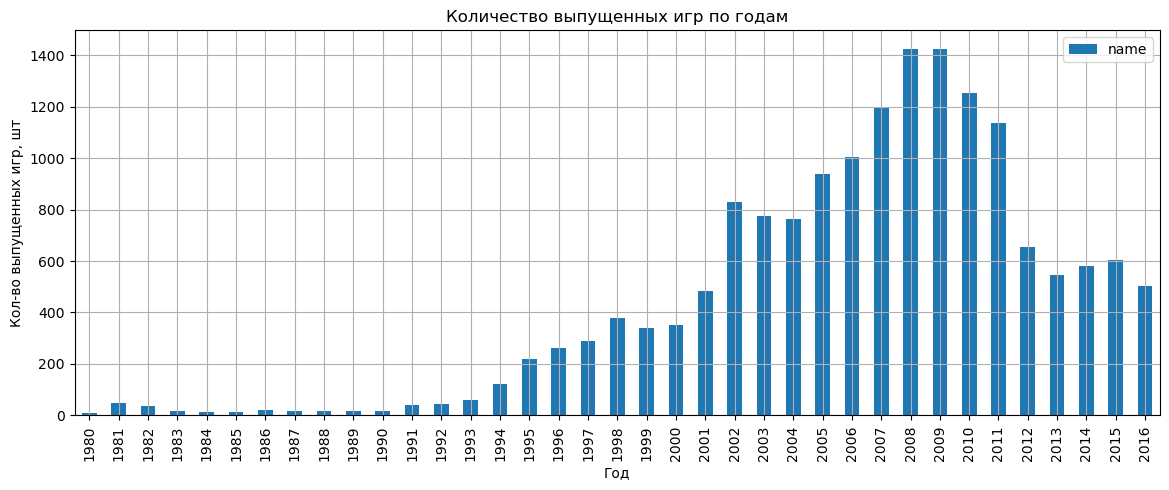

In [28]:
(
data
    .pivot_table(index='year_of_release', values='name', aggfunc='count')
    .plot(kind='bar', grid=True, title='Количество выпущенных игр по годам', xlabel='Год', ylabel='Кол-во выпущенных игр, шт', figsize=(14, 5))
);

**Выводы:** всплеск выпуска игр наблюдается с 1990 года, активный рост продолжался вплоть до 2009 года, после чего началось снижение количества выпускаемых игр.

### Количество продаж по платформам

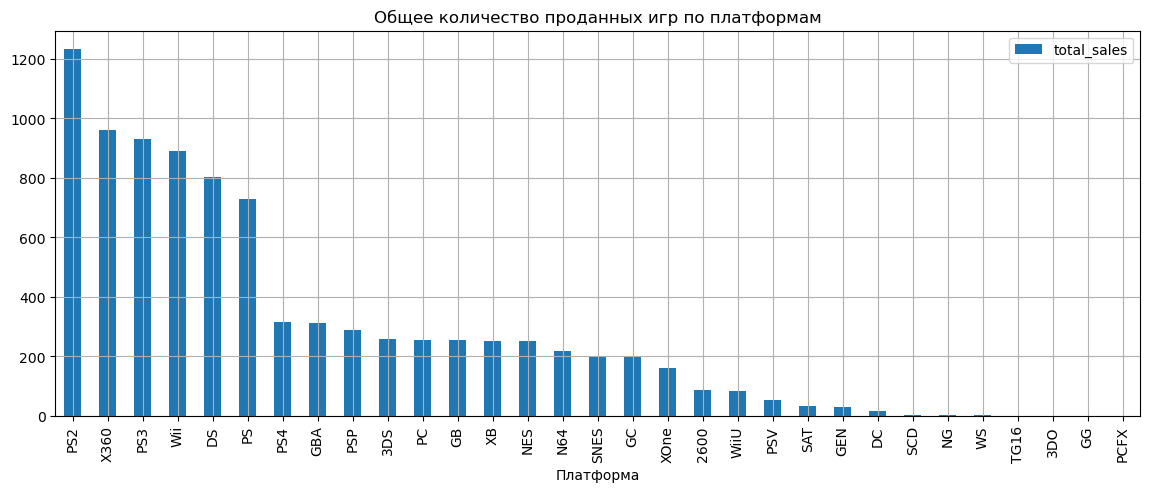

In [29]:
(
data
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .plot(kind='bar', grid=True, title='Общее количество проданных игр по платформам', xlabel='Платформа', figsize=(14,5))
);

Самые большие продажи зафиксированы на PS2, X360, PS3, Wii, DS и PS. Остальные существенно ниже. Посмотрим распределение продаж по годам на этих платформах.

PS2


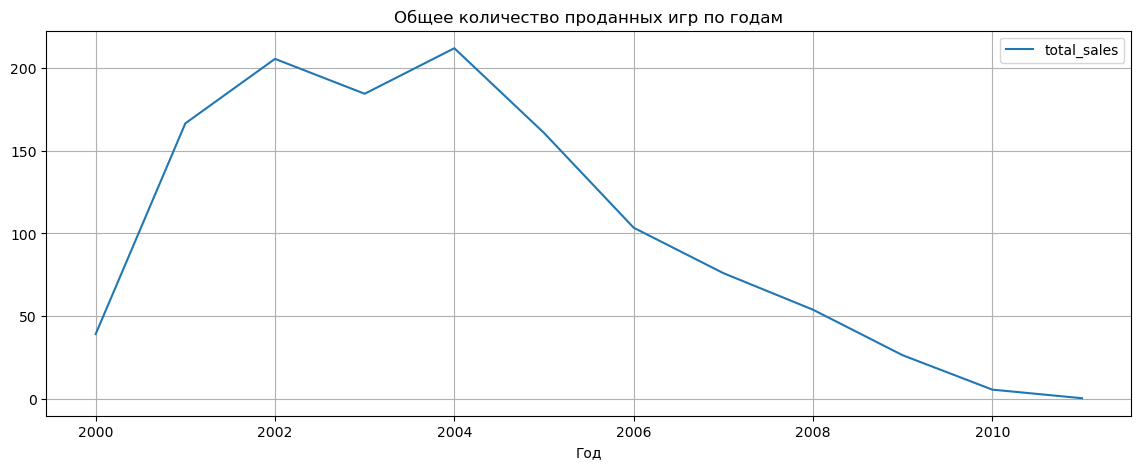

X360


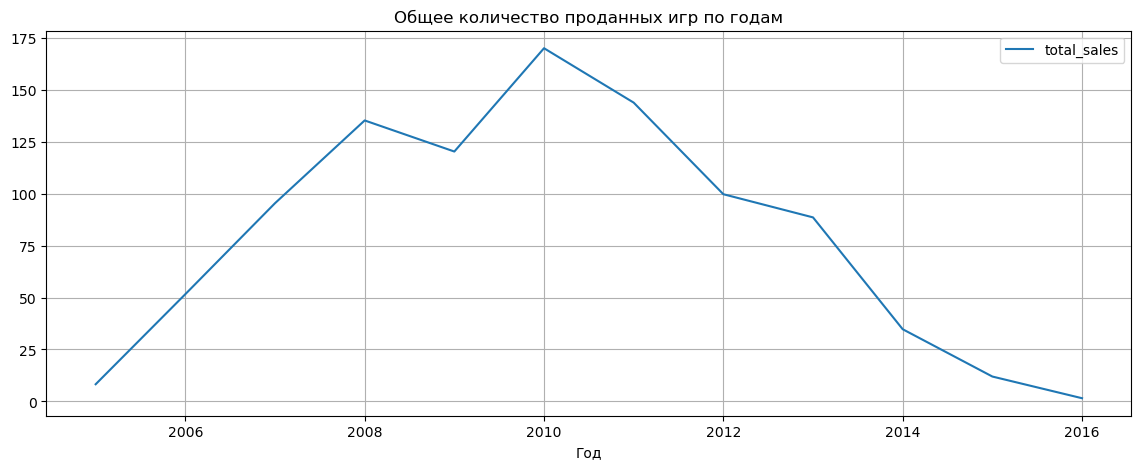

PS3


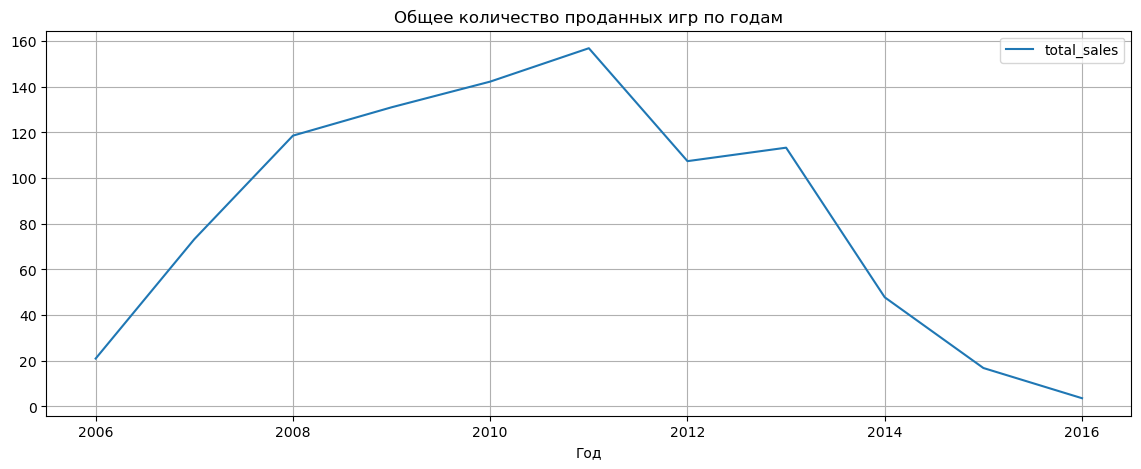

Wii


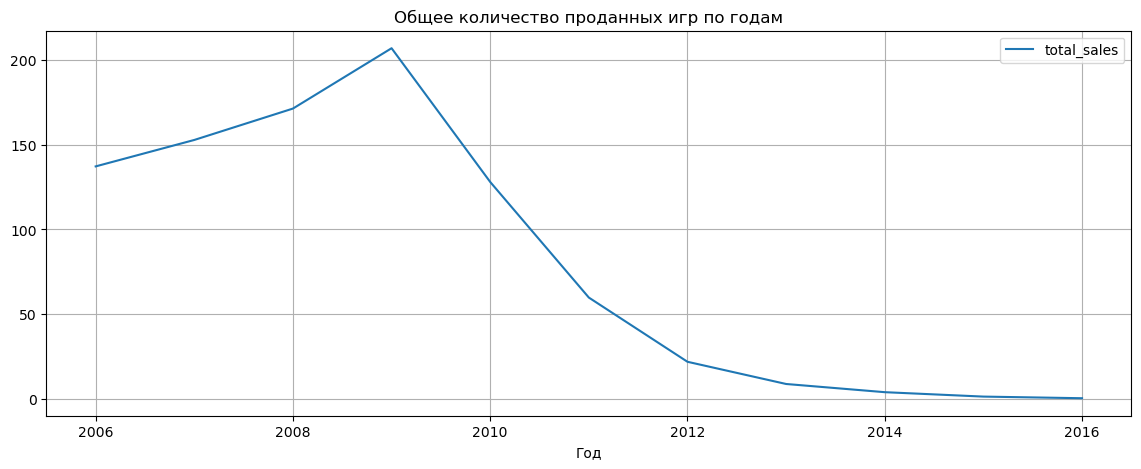

DS


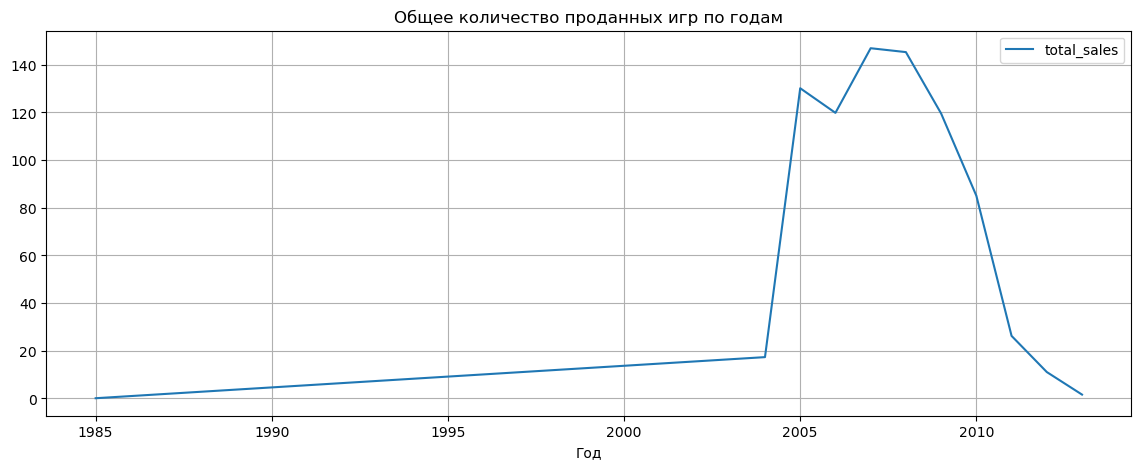

PS


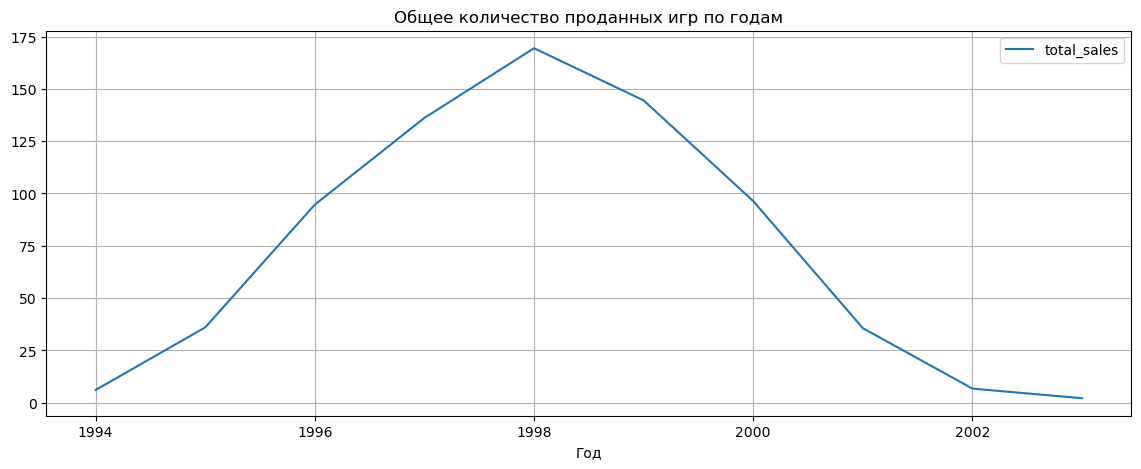

In [30]:
plat = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
for i in range(len(plat)):
    (
    data
        .query('platform == @plat[@i]')
        .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
        .plot(kind='line', grid=True, title='Общее количество проданных игр по годам', xlabel='Год', figsize=(14,5))
    );
    print(plat[i])
    plt.show()

In [31]:
# посмотрим распределение продаж по платформе DS по годам
data.query('platform == "DS"')\
    .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')\
    .sort_values(by='year_of_release')

,total_sales
year_of_release,
1985,0.02
2004,17.27
2005,130.14
2006,119.81
2007,146.94
2008,145.31
2009,119.54
2010,85.02
2011,26.18


In [32]:
# найдем индексы строк с продажами игр в 1985 на DS
data.loc[(data['platform'] == 'DS') & (data['year_of_release'] == 1985)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15704,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,0,0.0,non_rated,0.02


In [33]:
# число продаж незначительное, удалим эту строку
data = data.drop(index=15704)

In [34]:
# проверяем, что данных в таблице не осталось
data.loc[(data['platform'] == 'DS') & (data['year_of_release'] == 1985)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales


**Выводы:**<br>
В среднем срок жизни платформы составляет около 10 лет. На пик продаж платформа выходит за 2-4 года. Так как 2016 год может быть неполным, возьмем для анализа данные с 2014 года включительно. То есть мы сможем попытаться предсказать самые прибыльные платформы 2017 года.

### Актуальный период для анализа

In [35]:
data_actual = data.query('year_of_release >= 2014') # создадим новую переменную, куда поместим данные с 2014 года

In [36]:
print(data_actual.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   int64  
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     1689 non-null   int64  
 9   user_score       1689 non-null   float64
 10  rating           1689 non-null   object 
 11  total_sales      1689 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 171.5+ KB
None


In [37]:
display(data_actual.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0,0.0,non_rated,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,0,0.0,non_rated,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,0,0.0,non_rated,7.98


**Выводы:** создана новая переменная data_actual_head, куда помещены данные с 2014 года

### Анализ продаж по платформам

In [38]:
platforms_list = data_actual['platform'].unique() # посмотрим какие платформы попали в актуальный период
print(platforms_list)

['PS4' '3DS' 'XOne' 'WiiU' 'PS3' 'X360' 'PC' 'Wii' 'PSV' 'PSP']


In [39]:
# посмотрим платформы, которые продали больше всего игр за анализируемый период
data_actual.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales',ascending=False)

,total_sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22
WiiU,42.98
PC,27.05
PSV,22.40
Wii,5.07


In [40]:
# проанализируем продажи игр по платформам
data_platforms = data_actual.pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc=['count','sum'])
data_platforms.columns = ['games', 'total_sales']

PS4


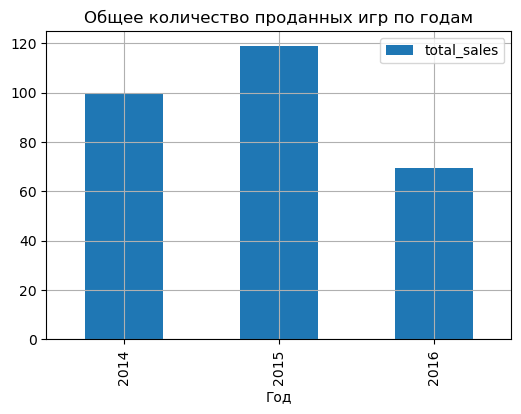

3DS


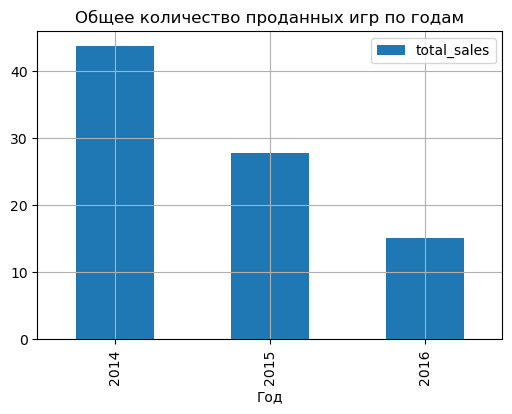

XOne


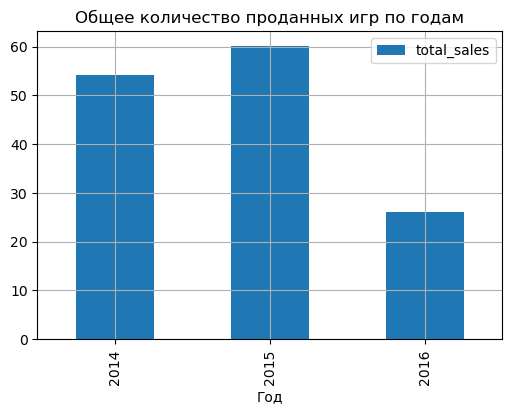

WiiU


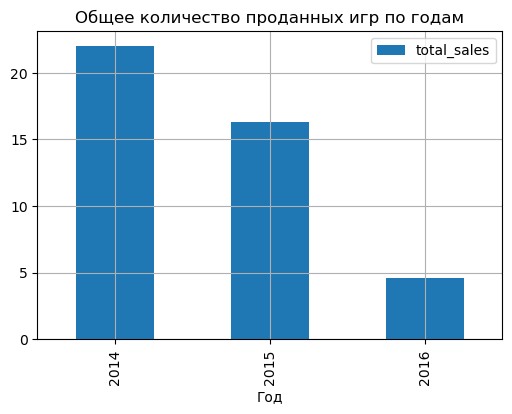

PS3


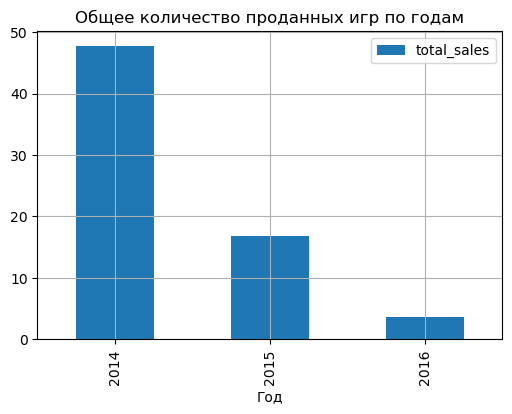

X360


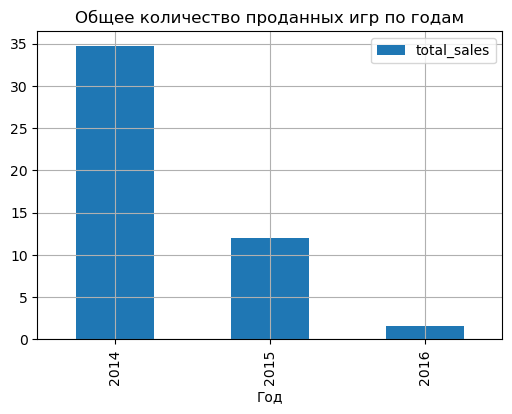

PC


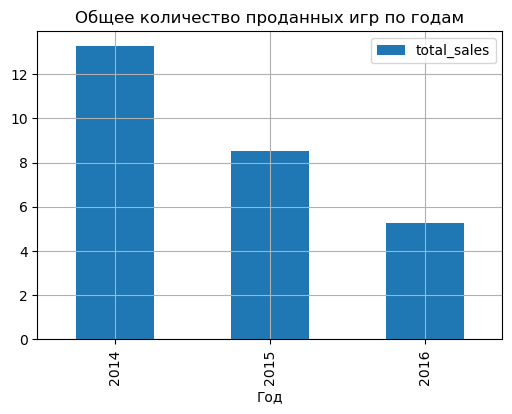

Wii


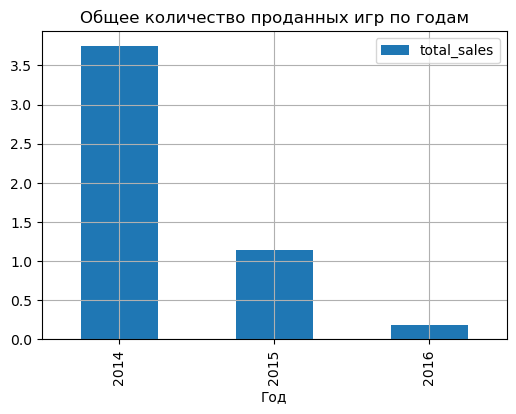

PSV


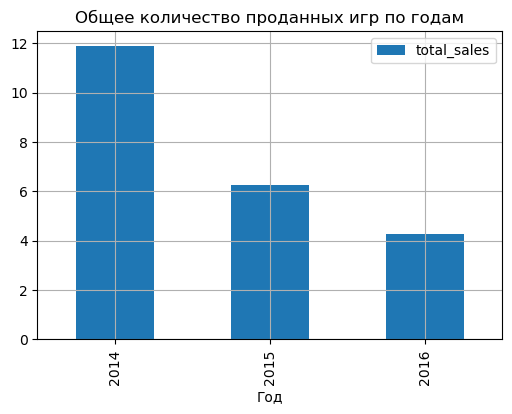

PSP


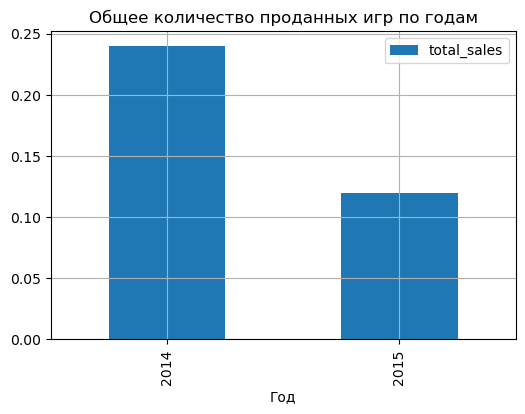

In [41]:
for i in range(len(platforms_list)):
    (
    data_platforms
        .query('platform == @platforms_list[@i]')
        .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
        .plot(kind='bar', grid=True, title='Общее количество проданных игр по годам', xlabel='Год', figsize=(6,4))
    );
    print(platforms_list[i])
    plt.show()

**Выводы:**<br>
Потенциально прибыльными являются платформы PS4, 3DS, XOne, WiiU, PC. Оставим для анализа только их.

### График «ящик с усами» по глобальным продажам игр в разбивке по платформам

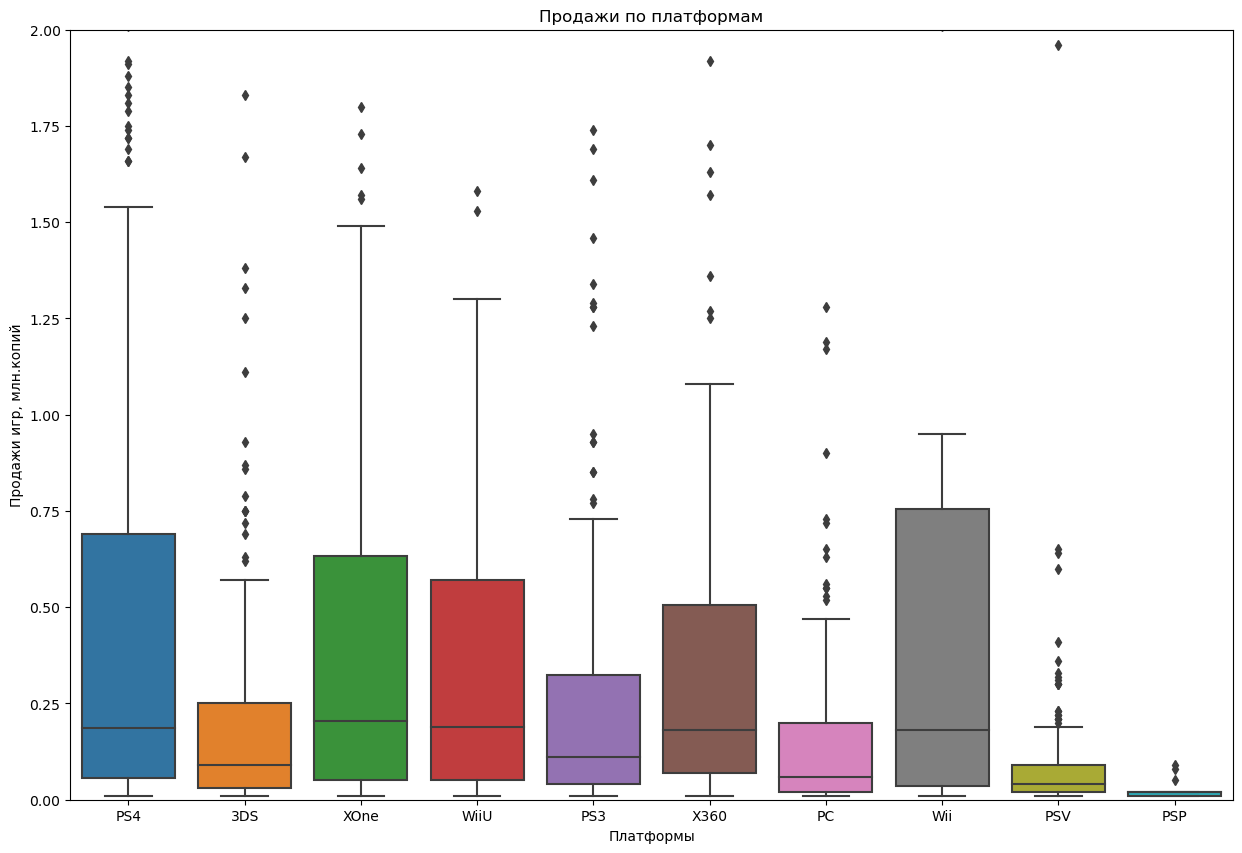

In [42]:
#platform_list = data_actual.query('platform in @platform_list')
#print(platform_list)
plt.figure(figsize=(15,10))
sns.boxplot(data=data_actual, x='platform', y='total_sales').\
    set(title='Продажи по платформам', xlabel='Платформы', ylabel='Продажи игр, млн.копий', ylim=(0,2))

plt.show()

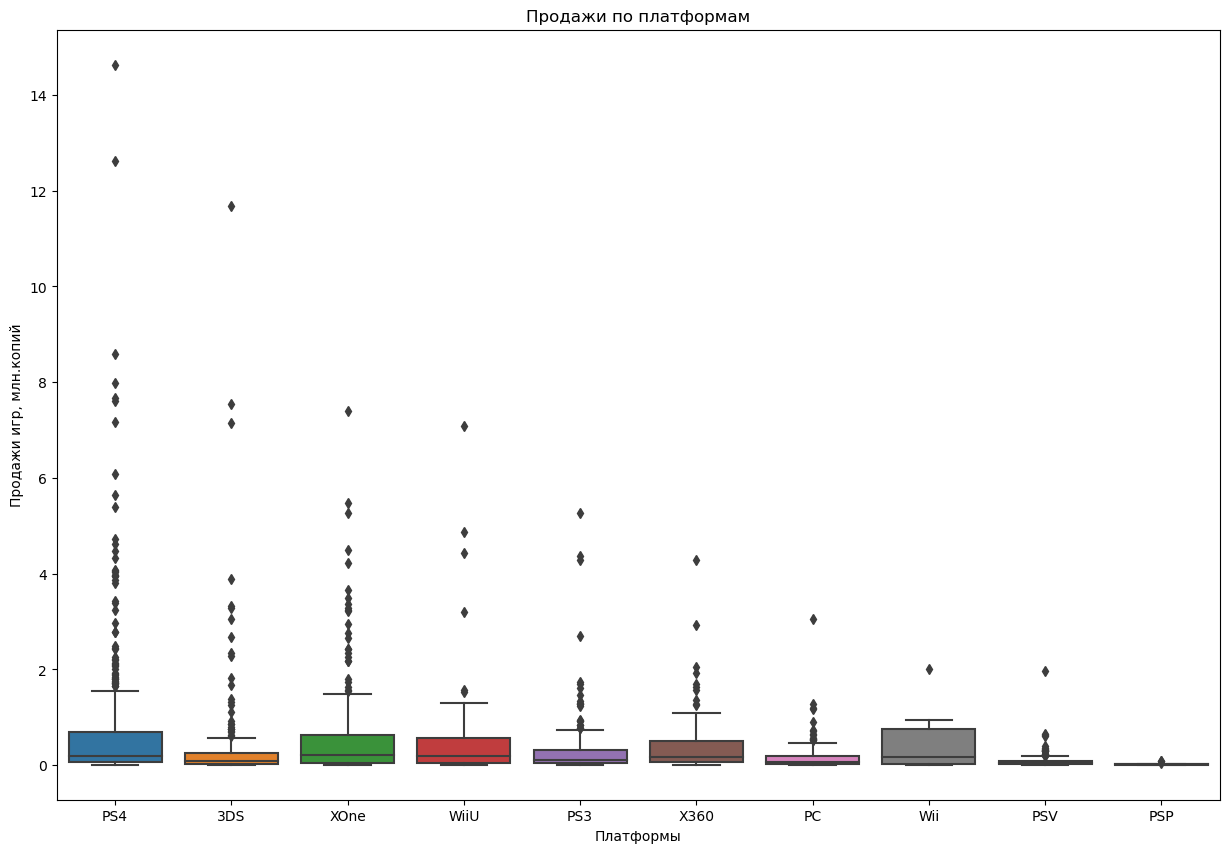

In [43]:
# изобразим тот же график в 100% масштабе
plt.figure(figsize=(15,10))
sns.boxplot(data=data_actual, x='platform', y='total_sales').\
    set(title='Продажи по платформам', xlabel='Платформы', ylabel='Продажи игр, млн.копий')
plt.show()

**Выводы:**<br>
Больше всего игр продается на платформах PS4, XOne, WiiU, Wii, X360, PS3 и 3DS.

### Влияние оценок критиков и пользователей на продажи в рамках одной платформы

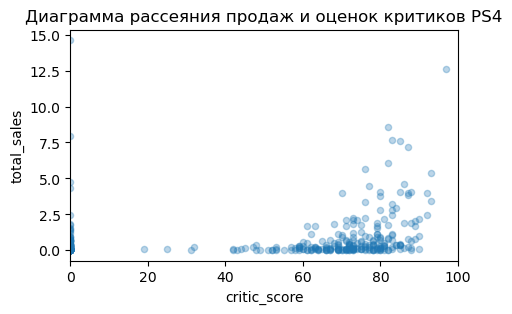

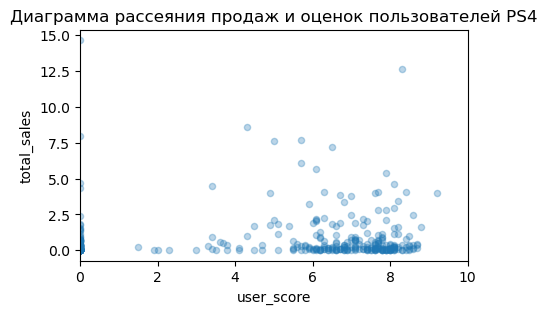

In [44]:
# посмотрим диаграмму рассеяния продаж от оценок критиков и пользователей.
plat = 'PS4'
(data_actual.query('platform == @plat')
    .plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,3),
    title='Диаграмма рассеяния продаж и оценок критиков PS4').set_xlim(0, 100)
)

(data_actual.query('platform == @plat')
    .plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,3),
         title='Диаграмма рассеяния продаж и оценок пользователей PS4').set_xlim(0, 10)
)

plt.show()

In [45]:
correlation = data_actual[['platform', 'total_sales', 'critic_score', 'user_score']]
correlation.query('platform == "PS4"').corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.211837,0.101448
critic_score,0.211837,1.000000,0.903670
user_score,0.101448,0.903670,1.000000


На графиках рассеяния прослеживается прямая связь между оценками и продажами игр. Матрица корреляции подтверждает, что данные корреляции слабые (0.2 между продажами и оценками критиков и 0.1 между продажами и оценками пользователями). При этом корреляция между оценками критиков и пользователей высокая - 0.9.

Посмотрим диаграммы рассеяния на других платформах: 3DS, XOne, WiiU, PC.

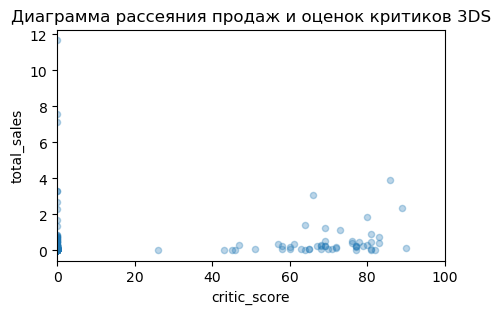

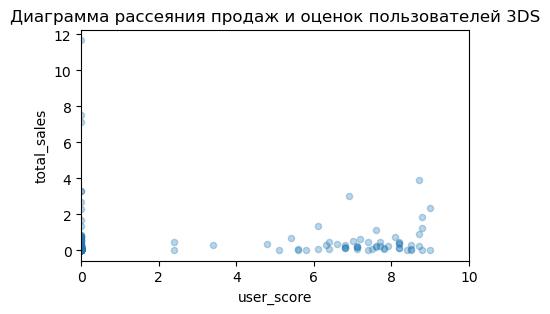

In [46]:
plat = '3DS'
(data_actual.query('platform == @plat')
    .plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,3),
    title='Диаграмма рассеяния продаж и оценок критиков 3DS').set_xlim(0, 100)
)

(data_actual.query('platform == @plat')
    .plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,3),
         title='Диаграмма рассеяния продаж и оценок пользователей 3DS').set_xlim(0, 10)
)

plt.show()

In [47]:
correlation = data_actual[['platform', 'total_sales', 'critic_score', 'user_score']]
correlation.query('platform == "3DS"').corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.053255,0.054922
critic_score,0.053255,1.000000,0.887491
user_score,0.054922,0.887491,1.000000


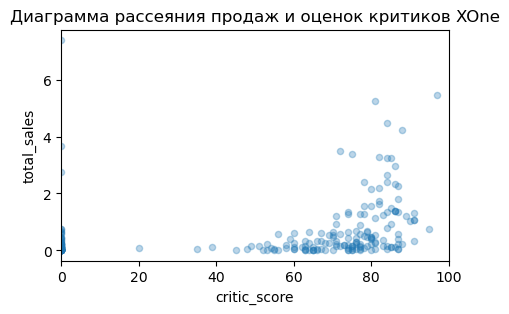

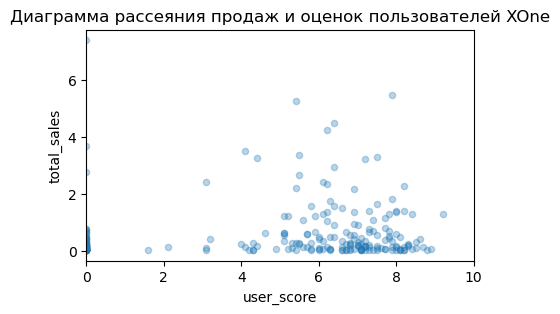

In [48]:
plat = 'XOne'
(data_actual.query('platform == @plat')
    .plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,3),
    title='Диаграмма рассеяния продаж и оценок критиков XOne').set_xlim(0, 100)
)

(data_actual.query('platform == @plat')
    .plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,3),
         title='Диаграмма рассеяния продаж и оценок пользователей XOne').set_xlim(0, 10)
)

plt.show()

In [49]:
correlation = data_actual[['platform', 'total_sales', 'critic_score', 'user_score']]
correlation.query('platform == "XOne"').corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.272518,0.102074
critic_score,0.272518,1.000000,0.793371
user_score,0.102074,0.793371,1.000000


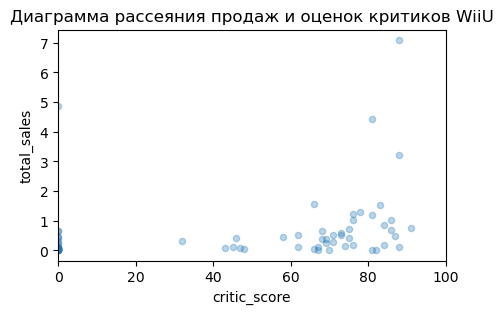

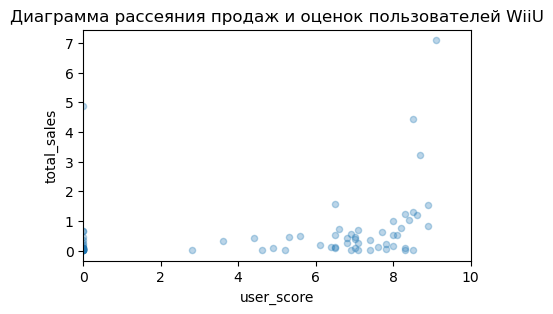

In [50]:
plat = 'WiiU'
(data_actual.query('platform == @plat')
    .plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,3),
    title='Диаграмма рассеяния продаж и оценок критиков WiiU').set_xlim(0, 100)
)

(data_actual.query('platform == @plat')
    .plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,3),
         title='Диаграмма рассеяния продаж и оценок пользователей WiiU').set_xlim(0, 10)
)

plt.show()

In [51]:
correlation = data_actual[['platform', 'total_sales', 'critic_score', 'user_score']]
correlation.query('platform == "WiiU"').corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.292222,0.264631
critic_score,0.292222,1.000000,0.831632
user_score,0.264631,0.831632,1.000000


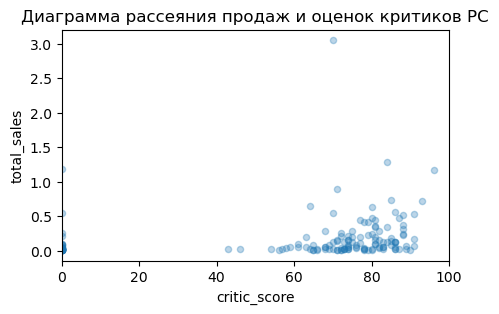

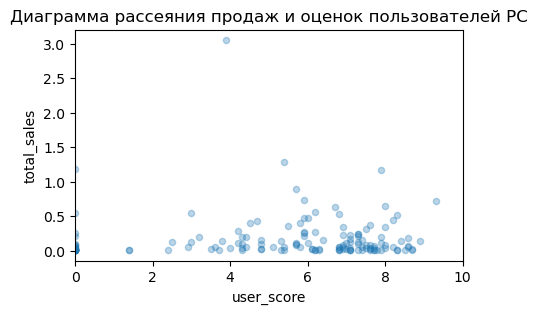

In [52]:
plat = 'PC'
(data_actual.query('platform == @plat')
    .plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,3),
    title='Диаграмма рассеяния продаж и оценок критиков PC').set_xlim(0, 100)
)

(data_actual.query('platform == @plat')
    .plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3, figsize=(5,3),
         title='Диаграмма рассеяния продаж и оценок пользователей PC').set_xlim(0, 10)
)

plt.show()

In [53]:
correlation = data_actual[['platform', 'total_sales', 'critic_score', 'user_score']]
correlation.query('platform == "PC"').corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.184312,0.061709
critic_score,0.184312,1.000000,0.786678
user_score,0.061709,0.786678,1.000000


**Выводы:**<br>
Зависимость продаж и оценок по платформам немного отличается, степень корреляции невысокая. При этом стабильно наблюдается высокая связь между оценками критиков и пользователей - от 0.78 до 0.9.

### Общее распределение игр по жанрам

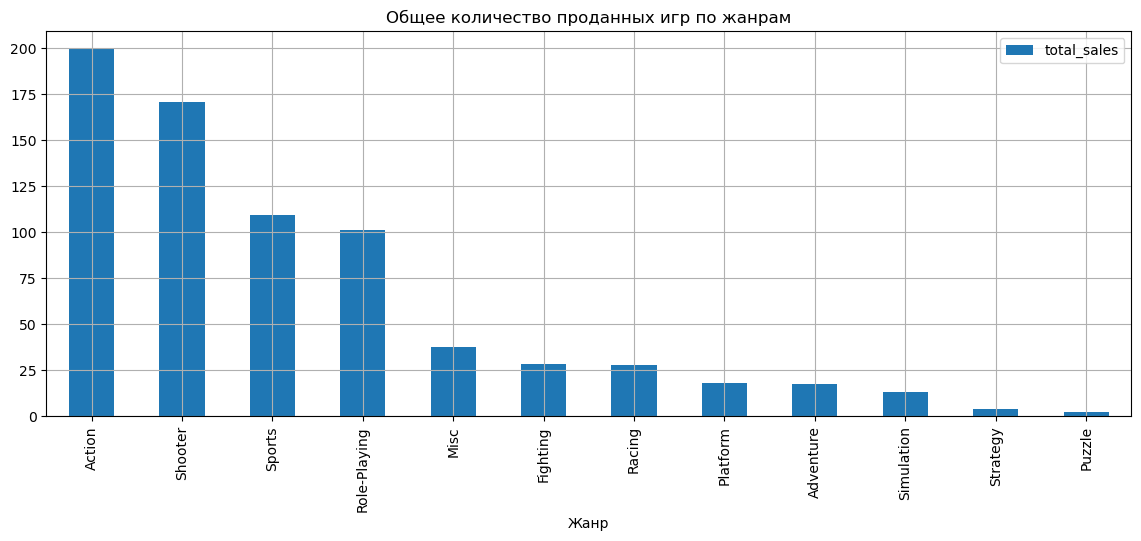

In [54]:
(
data_actual
    .pivot_table(index='genre', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .plot(kind='bar', grid=True, title='Общее количество проданных игр по жанрам', xlabel='Жанр', figsize=(14,5))
);

На первый взгляд кажется, что выделяются продажи игр жанра action. Но давайте посмотрим как распределяется количество продаж на одну игру в каждом жанре.

In [55]:
data_sales_by_genre = data_actual.pivot_table(index=['genre', 'name'], values='total_sales', aggfunc='sum')
data_sales_by_genre.columns = ['total_sales']
data_sales_by_genre.sort_values(by='total_sales',ascending=False)

total_sales
genre      name                                                           
Shooter    Call of Duty: Black Ops 3                                 25.67
           Call of Duty: Advanced Warfare                            21.97
Action     Grand Theft Auto V                                        19.26
Sports     FIFA 15                                                   17.37
           FIFA 16                                                   16.30
...                                                                    ...
Simulation Farming Simulator 2014                                     0.01
Action     Crows: Burning Edge                                        0.01
Simulation Farming 2017 - The Simulation                              0.01
Misc       4 Play Collection - Dark Mysteries                         0.01
Action     Chou Ezaru wa Akai Hana: Koi wa Tsuki ni Shirub...         0.01

[956 rows x 1 columns]

In [56]:
games_by_genre = data_sales_by_genre.pivot_table(index='genre', values='total_sales', aggfunc=['sum','count'])
games_by_genre.columns = ['total_sales', 'games']
games_by_genre['sales_per_game'] = games_by_genre['total_sales'] / games_by_genre['games']

In [57]:
print(games_by_genre.sort_values(by='sales_per_game', ascending=False))

              total_sales  games  sales_per_game
genre                                           
Shooter            170.94     51        3.351765
Sports             109.48     55        1.990545
Racing              27.52     28        0.982857
Fighting            28.22     34        0.830000
Platform            18.09     22        0.822273
Role-Playing       101.44    151        0.671788
Action             199.36    338        0.589822
Misc                37.55     73        0.514384
Simulation          13.13     35        0.375143
Puzzle               2.21     10        0.221000
Adventure           17.55    127        0.138189
Strategy             3.96     32        0.123750


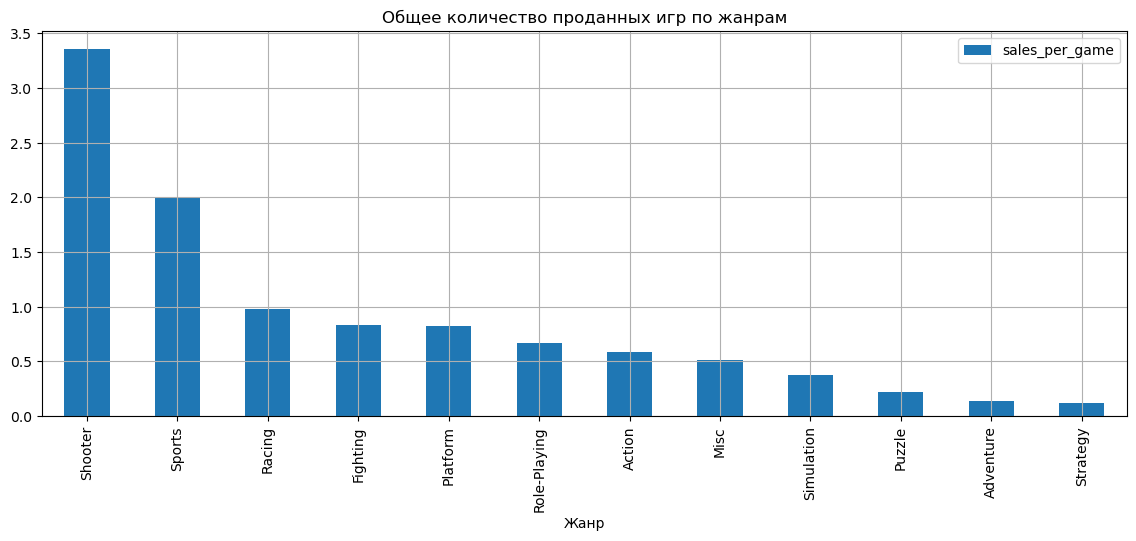

In [58]:
games_by_genre.sort_values(by='sales_per_game',ascending=False)\
    .plot(kind='bar',
          grid=True,
          title='Общее количество проданных игр по жанрам',
          y='sales_per_game',
          xlabel='Жанр',
          figsize=(14,5));

**Выводы:**<br>
- в период 2014-2016 годов основную долю продаж составили игры жанров Action, Shooter, Sports и RolePlaying;
- лидерами по числу продаж на одну игру являются жанры shooter и sport. Далее количество продаж значительно падает и находится в пределе 1 млн копий на одну игру.

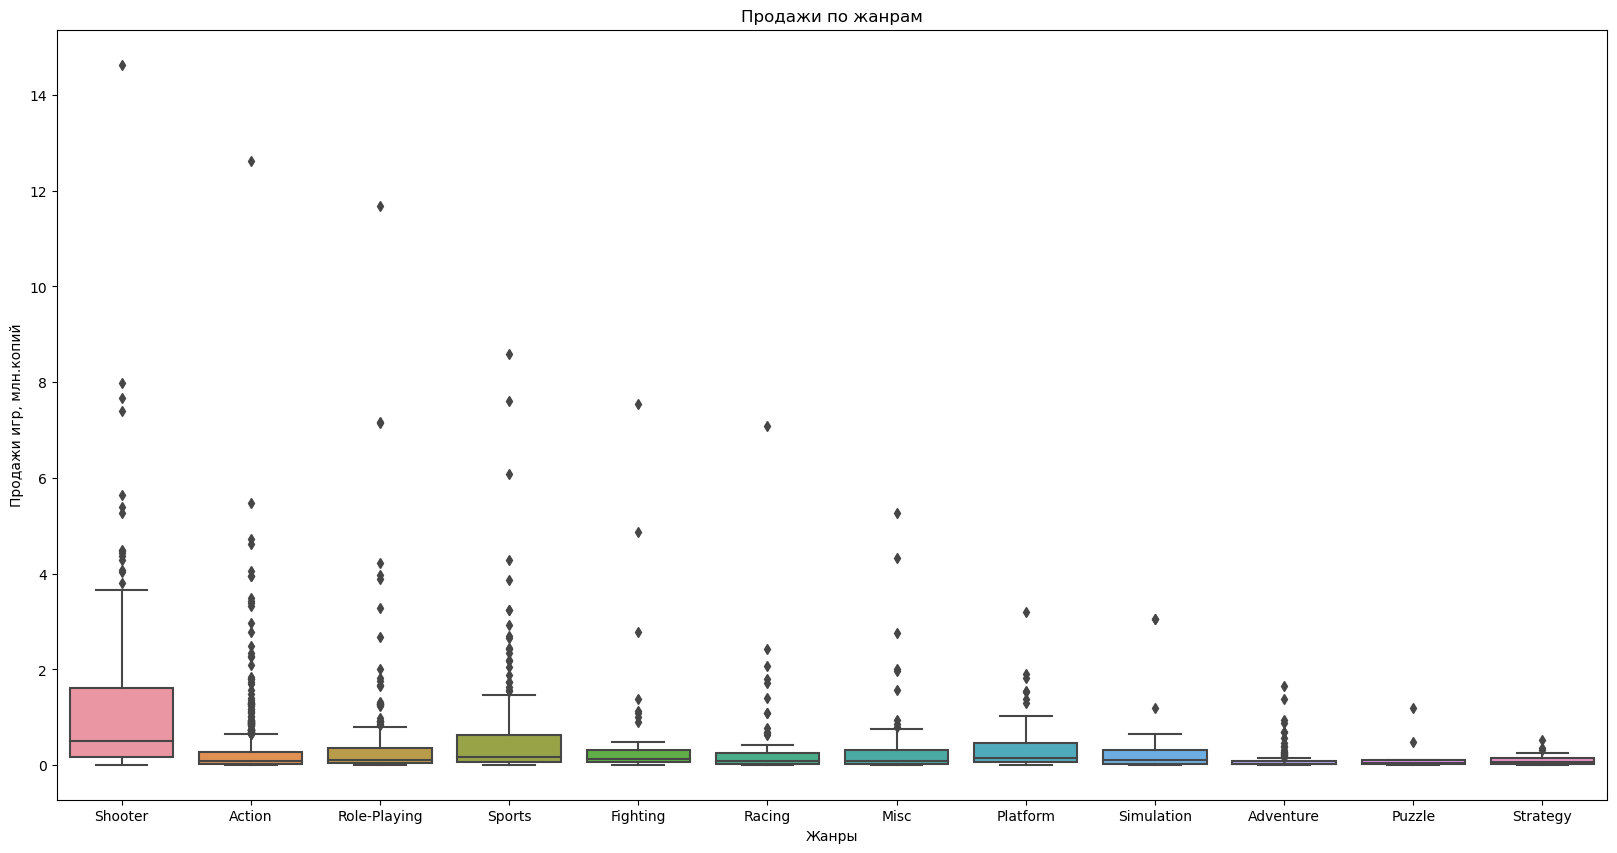

In [59]:
# построим диаграммы размаха по продажам игр по жанрам
plt.figure(figsize=(20,10))
sns.boxplot(data=data_actual, x='genre', y='total_sales').\
    set(title='Продажи по жанрам', xlabel='Жанры', ylabel='Продажи игр, млн.копий')
plt.show()

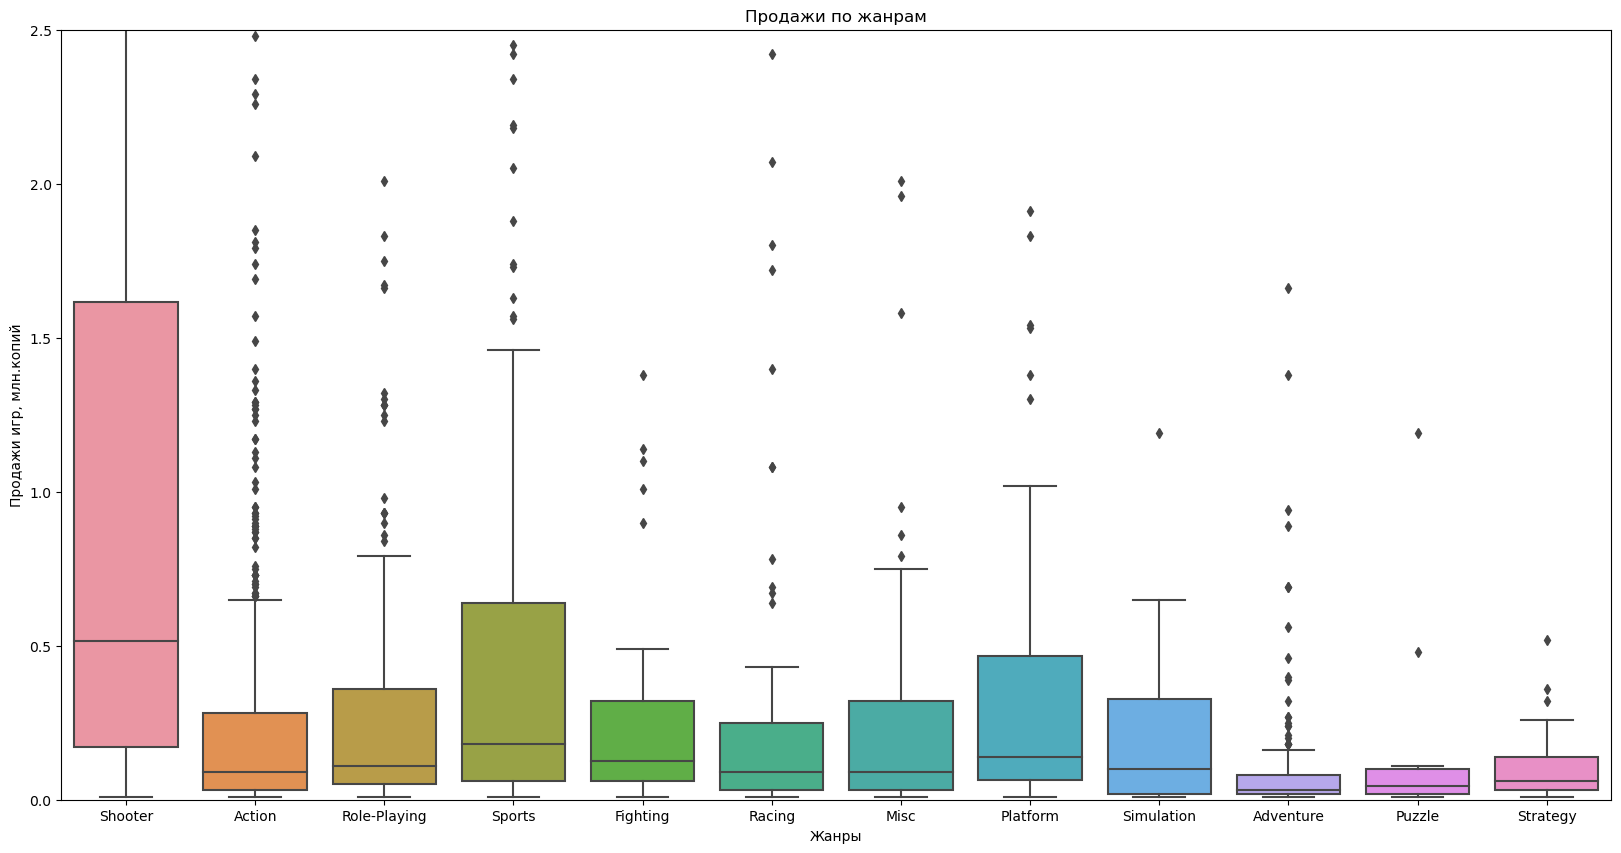

In [60]:
# построим диаграммы размаха по продажам игр по жанрам
plt.figure(figsize=(20,10))
sns.boxplot(data=data_actual, x='genre', y='total_sales').\
    set(title='Продажи по жанрам', xlabel='Жанры', ylabel='Продажи игр, млн.копий', ylim=(0,2.5))
plt.show()

[Оглавление](#section_id7)

## 4. Портреты пользователей каждого региона
<a id='section_id4'></a>

Строить портреты и проводить анализ будем только по актуальным периодам - данным, находящимся в переменной data_actual. Посмотреть на распределение платформ по регионам будет удобно с помощью круговых диаграмм.

### Самые популярные платформы

In [61]:
# сначала определим топ 5 платформ для каждого региона продаж
data_actual_grouped = data_actual.pivot_table(index='platform', values=['na_sales','eu_sales','jp_sales'], aggfunc='sum').reset_index()
top_platforms_na = list(data_actual_grouped.nlargest(5,'na_sales')['platform'])
display(top_platforms_na)
top_platforms_eu = list(data_actual_grouped.nlargest(5,'eu_sales')['platform'])
display(top_platforms_eu)
top_platforms_jp = list(data_actual_grouped.nlargest(5,'jp_sales')['platform'])
display(top_platforms_jp)
# напишем функции, которые добавят новую колонку со значением other_platforms, если платформа не входит в топ-5 региона
def other_platforms(platform):
    if platform in top_platforms_na:
        return platform
    else:
        return 'other platforms'
data_actual['top_platforms_na'] = data_actual['platform'].apply(other_platforms)

def other_platforms(platform):
    if platform in top_platforms_eu:
        return platform
    else:
        return 'other platforms'
data_actual['top_platforms_eu'] = data_actual['platform'].apply(other_platforms)

def other_platforms(platform):
    if platform in top_platforms_jp:
        return platform
    else:
        return 'other platforms'
data_actual['top_platforms_jp'] = data_actual['platform'].apply(other_platforms)

display(data_actual.head())

['PS4', 'XOne', 'X360', '3DS', 'PS3']

['PS4', 'XOne', 'PS3', 'PC', '3DS']

['3DS', 'PS4', 'PSV', 'PS3', 'WiiU']

/var/folders/xz/5gzk6dd95rx44y_jqhmghjyc0000gn/T/ipykernel_78677/2681902923.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_actual['top_platforms_na'] = data_actual['platform'].apply(other_platforms)
/var/folders/xz/5gzk6dd95rx44y_jqhmghjyc0000gn/T/ipykernel_78677/2681902923.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_actual['top_platforms_eu'] = data_actual['platform'].apply(other_platforms)
/var/folders/xz/5gzk6dd95rx44y_jqhmghjyc0000gn/T/ipykernel_78677/2681902923.py:29: SettingWi

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,top_platforms_na,top_platforms_eu,top_platforms_jp
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0,0.0,non_rated,14.63,PS4,PS4,PS4
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62,PS4,PS4,PS4
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,0,0.0,non_rated,11.68,3DS,3DS,3DS
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58,PS4,PS4,PS4
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,0,0.0,non_rated,7.98,PS4,PS4,PS4


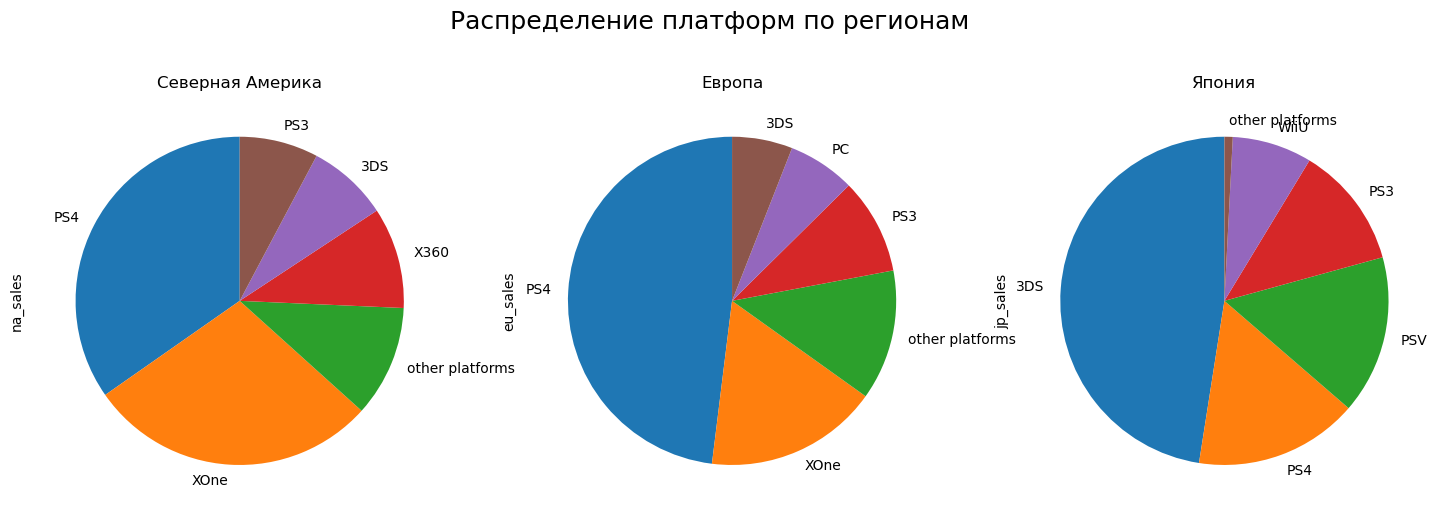

In [62]:
fig = plt.figure(figsize=(18,6))
fig.suptitle('Распределение платформ по регионам', fontsize=18) 

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

(data_actual.groupby(by='top_platforms_na').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False)\
             .plot(kind='pie', legend = False, ax=ax1, subplots=True, startangle=90))
(data_actual.groupby(by='top_platforms_eu').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False)\
             .plot(kind='pie', legend = False, ax=ax2, subplots=True, startangle=90))
(data_actual.groupby(by='top_platforms_jp').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False)\
             .plot(kind='pie', legend = False, ax=ax3, subplots=True, startangle=90))

ax1.set_title('Северная Америка')
ax2.set_title('Европа')
ax3.set_title('Япония')


plt.show()

**Выводы:**<br>
- в Северной Америке и Европе явно выделяются продажи на PS4 и XOne - они занимают около 70% рынка. Далее популярность платформ значительно падает, но 2 из них пересекаются в ТОП-5 по этим регионам: 3DS и PS3.
- в Японии наибоее популярна 3DS - она занимает почти половину рынка. Вероятно это объясняется тем, что Nintendo явяляется локальной разработкой японцев.

### Самые популярные жанры

In [63]:
# сначала определим топ 5 жанров для каждого региона продаж
data_actual_grouped = data_actual.pivot_table(index='genre', values=['na_sales','eu_sales','jp_sales'], aggfunc='sum').reset_index()
top_genres_na = list(data_actual_grouped.nlargest(5,'na_sales')['genre'])
display(top_genres_na)
top_genres_eu = list(data_actual_grouped.nlargest(5,'eu_sales')['genre'])
display(top_genres_eu)
top_genres_jp = list(data_actual_grouped.nlargest(5,'jp_sales')['genre'])
display(top_genres_jp)
# напишем функции, которые добавят новую колонку со значением other_genres, если жанр не входит в топ-5 региона
def other_genres(genre):
    if genre in top_genres_na:
        return genre
    else:
        return 'other genres'
data_actual['top_genres_na'] = data_actual['genre'].apply(other_genres)

def other_genres(genre):
    if genre in top_genres_eu:
        return genre
    else:
        return 'other genres'
data_actual['top_genres_eu'] = data_actual['genre'].apply(other_genres)

def other_genres(genre):
    if genre in top_genres_jp:
        return genre
    else:
        return 'other genres'
data_actual['top_genres_jp'] = data_actual['genre'].apply(other_genres)

display(data_actual.head())

['Shooter', 'Action', 'Sports', 'Role-Playing', 'Misc']

['Action', 'Shooter', 'Sports', 'Role-Playing', 'Racing']

['Role-Playing', 'Action', 'Fighting', 'Misc', 'Shooter']

/var/folders/xz/5gzk6dd95rx44y_jqhmghjyc0000gn/T/ipykernel_78677/360803024.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_actual['top_genres_na'] = data_actual['genre'].apply(other_genres)
/var/folders/xz/5gzk6dd95rx44y_jqhmghjyc0000gn/T/ipykernel_78677/360803024.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_actual['top_genres_eu'] = data_actual['genre'].apply(other_genres)
/var/folders/xz/5gzk6dd95rx44y_jqhmghjyc0000gn/T/ipykernel_78677/360803024.py:29: SettingWithCopyWarning: 
A val

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,top_platforms_na,top_platforms_eu,top_platforms_jp,top_genres_na,top_genres_eu,top_genres_jp
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0,0.0,non_rated,14.63,PS4,PS4,PS4,Shooter,Shooter,Shooter
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62,PS4,PS4,PS4,Action,Action,Action
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,0,0.0,non_rated,11.68,3DS,3DS,3DS,Role-Playing,Role-Playing,Role-Playing
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58,PS4,PS4,PS4,Sports,Sports,other genres
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,0,0.0,non_rated,7.98,PS4,PS4,PS4,Shooter,Shooter,Shooter


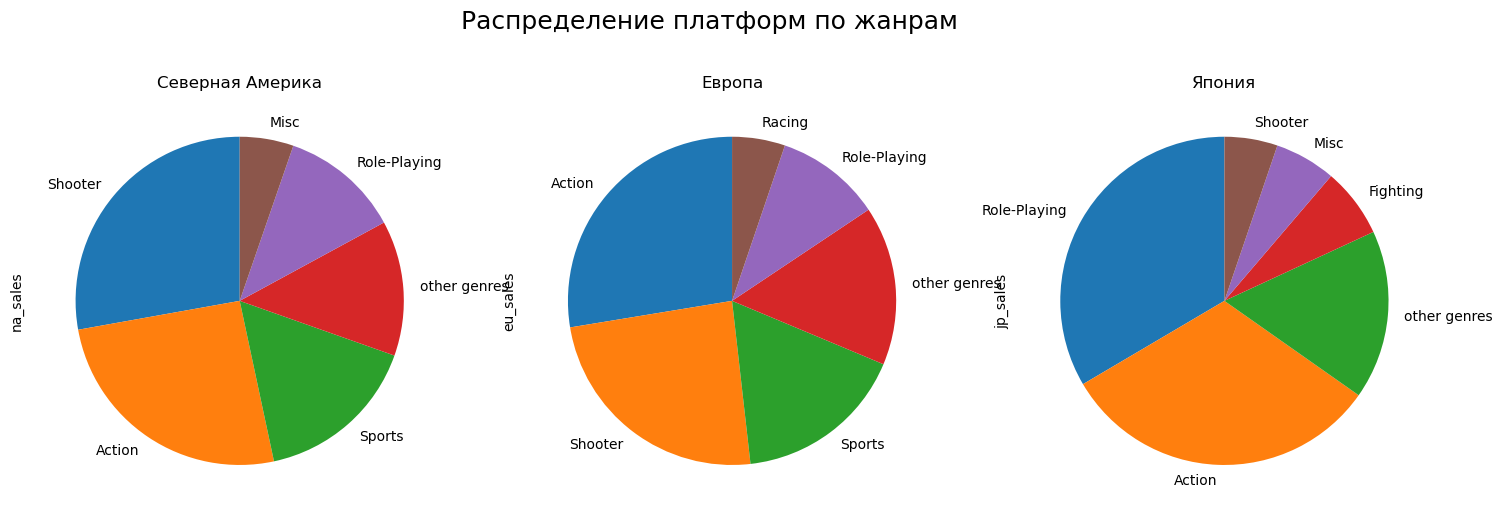

In [64]:
fig = plt.figure(figsize=(18,6))
fig.suptitle('Распределение платформ по жанрам', fontsize=18) 

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

data_actual.groupby(by='top_genres_na').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False)\
             .plot(kind = 'pie', legend = False, ax=ax1, subplots=True, startangle=90);

data_actual.groupby(by='top_genres_eu').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False)\
             .plot(kind='pie', legend = False, ax=ax2, subplots=True, startangle=90);

data_actual.groupby(by='top_genres_jp').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False)\
             .plot(kind='pie', legend = False, ax=ax3, subplots=True, startangle=90);

ax1.set_title('Северная Америка')
ax2.set_title('Европа')
ax3.set_title('Япония')


plt.show()

**Выводы:**<br>
- в Северной Америке и Европе наиболее популярны жанры shooter, action, sports и role-playing. Они занимают 75-80% процента рынка и пользуются примерно одинаковой популярностью в Северной Америке и Европе;
- в Японии наибоее популярны role-playing, actiong и fighting.

### Влияние рейтинга ESRB на продажи в регионах

In [65]:
data_actual.value_counts('rating') # посмотрим как распределился рейтинг по играм

rating
non_rated    749
T            271
M            265
E            219
E10+         185
dtype: int64

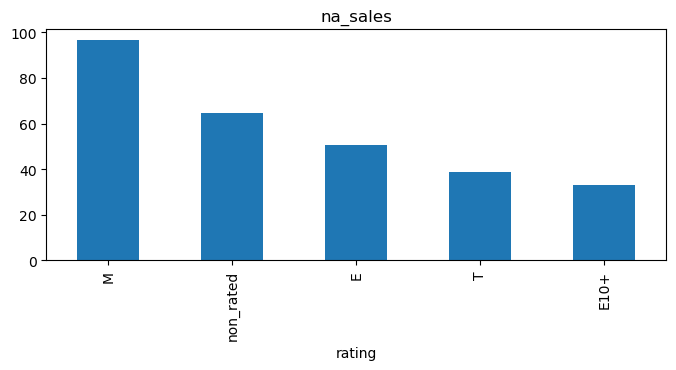

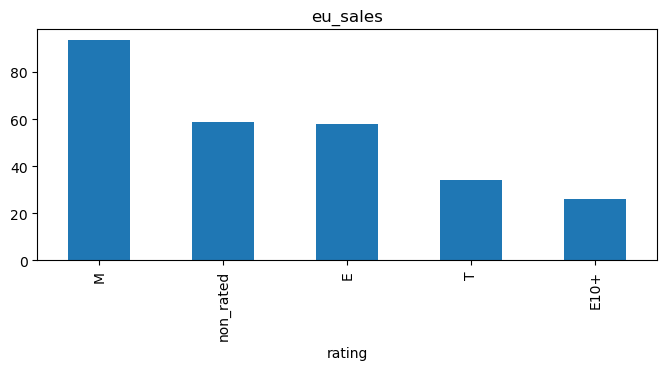

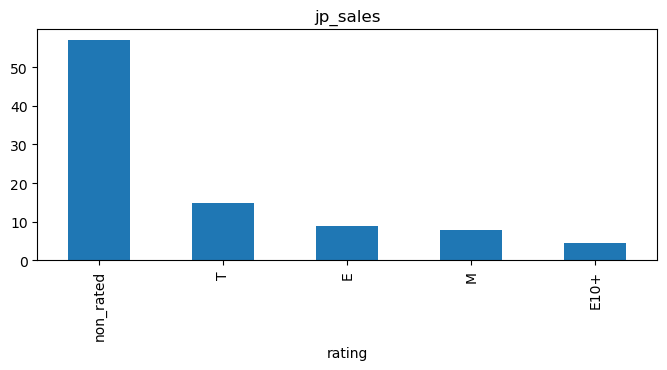

In [66]:
data_actual.groupby(by='rating').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False)\
             .plot(kind = 'bar', legend = False, subplots=True, figsize=(8,3));

data_actual.groupby(by='rating').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False)\
             .plot(kind='bar', legend = False, subplots=True, figsize=(8,3));

data_actual.groupby(by='rating').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False)\
             .plot(kind='bar', legend = False, subplots=True, figsize=(8,3));

**Выводы:**
- в Северной Америке и Европе распределение рейтингов примерно одинаковое: в основном продаются игры с рейтингом M, далее те, которые не были оценены и следом категория E;
- в Японии львиная доля игр не получила рейтинг, далее следуют игры с рейтингом T. Рейтинг E и M получило примерно одинаковое кол-во игр;
- во всех анализируемых регионах наименее популярными являются игры с рейтингом E10+.

[Оглавление](#section_id7)

## 5. Проверка гипотез
<a id='section_id5'></a>

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Гипотезы:<br>
- H0: средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- H1: средние пользовательские рейтинги платформ Xbox One и PC разные.

In [67]:
xone = data_actual[(data_actual['platform'] == 'XOne') & (data_actual['user_score'] > 0)]['user_score']
pc = data_actual[(data_actual['platform'] == 'PC') & (data_actual['user_score'] > 0)]['user_score']

alpha = 0.05 # критический уровень статистической значимости
results = st.ttest_ind(xone, pc)

print('p-value (уровень значимости):', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value (уровень значимости): 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


**Выводы:**<br>
Значение p-value показывает: вероятность случайно получить такое или большее различие равно 10%. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между пользовательскими оценками платформ.

### Средние пользовательские рейтинги жанров Action и Sports разные

Гипотезы:<br>
- H0: средние пользовательские рейтинги жанров Action и Sports одинаковые;
- H1: средние пользовательские рейтинги жанров Action и Sports разные.

In [68]:
action = data_actual[(data_actual['genre'] == 'Action') & (data_actual['user_score'] > 0)]['user_score']
sports = data_actual[(data_actual['genre'] == 'Sports') & (data_actual['user_score'] > 0)]['user_score']

alpha = 0.05 # критический уровень статистической значимости
results = st.ttest_ind(action, sports)

print('p-value (уровень значимости):', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value (уровень значимости): 2.8711147985105864e-19
Отвергаем нулевую гипотезу


**Выводы:**<br>
Значение p-value показывает: вероятность случайно получить такое различие менее 1%. Это означает, что между пользовательскими рейтингами жанров Action и Sports есть статистически значимые различия.

[Оглавление](#section_id7)

## 6. Результаты исследования
<a id='section_id6'></a>

### Обзор данных

Для анализа использовался датасет с данным по продажам игр на разных платформах до 2016 года.

### Предобработка данных

В ходе предобработке данных было выполнено следующее:<br>
- названия столбцов приведены к нижнему регистру;
- удалены строки с пропусками в колонках name, genre, year of release - менее 5%, несущественно для проведения исследования;
- пропуски в колонке critic_score заменены на 0;
- пропуски в колонке user_score заменены на 0, значения tbd на -1 - это необходимо, чтобы превести формат к числам с плавающей точкой и анализировать их;
- пропуски в колонке rating заменены на non_rated;
- изменен тип данных year_of_release и critic_score на int, user_score на float.
- добавлена колонка total_sales для расчета общего количества проданных копий по всем регионам.

### Исследовательский анализ данных

1. Всплеск выпуска игр наблюдается с 1990 года, активный рост продолжался вплоть до 2009 года, после чего началось снижение количества выпускаемых игр.
2. Самые большие продажи зафиксированы на PS2, X360, PS3, Wii, DS и PS. Остальные существенно ниже.
3. В среднем срок жизни платформы составляет около 10 лет. На пик продаж платформа выходит за 2-4 года. Так как 2016 год может быть неполным, для анализа взяты данные с 2014 года включительно.
4. Больше всего игр в анализируемом периоде продается на платформах PS4, XOne и WiiU.
5. Зависимость продаж и оценок по платформам немного отличается, степень корреляции невысокая. При этом стабильно наблюдается высокая связь между оценками критиков и пользователей - от 0.78 до 0.9.
6. В период 2014-2016 годов основную долю продаж составили игры жанров Action, Shooter, Sports и RolePlaying. Лидерами по числу продаж на одну игру являются жанры shooter и sport. Далее количество продаж значительно падает и находится в пределе 1 млн копий на одну игру.
7. В Северной Америке и Европе явно выделяются продажи на PS4 и XOne - они занимают около 70% рынка. Далее популярность платформ значительно падает, но 2 из них пересекаются в ТОП-5 по этим регионам: 3DS и PS3.
8. В Японии наибоее популярна 3DS - она занимает почти половину рынка. Вероятно это объясняется тем, что Nintendo явяляется локальной разработкой японцев.
9. В Северной Америке и Европе наиболее популярны жанры shooter, action, sports и role-playing. Они занимают 75-80% процента рынка и пользуются примерно одинаковой популярностью в Северной Америке и Европе;
10. В Японии наибоее популярны role-playing.
11. В Северной Америке и Европе распределение рейтингов примерно одинаковое: в основном продаются игры с рейтингом M, далее те, которые не были оценены и следом категория E;
12. В Японии львиная доля игр не получила рейтинг, далее следуют игры с рейтингом T. Рейтинг E и M получило примерно одинаковое кол-во игр;
13. Во всех анализируемых регионах наименее популярными являются игры с рейтингом E10+.

### Общий вывод

Планируя продажи на 2017 год следует делать акцент на следующее:
1. В Северной Америке и Европе необходимо делать акцент на продажу игр на PS4 и XOne жанров shooter, action, sports и role-playing. В Японии на 3DS и жанр role-playing.
2. Во всех странах наименее популярны игры с рейтингом E10+, наиболее популярны E и M.